In [42]:
from typing import Callable, Iterable
import numpy as np
from TwoDimProblem import TwoDimProblem
import matplotlib.pyplot as plt

%matplotlib inline

In [81]:
a = np.arange(5)

# Define Functions and MLP

### Activation Functions

In [53]:
def sigmoid(X: np.ndarray):
    return 1.0 / (1.0 + np.exp(-X))
def dSigmoid(X: np.ndarray):
    a = 1.0 / (1.0 + np.exp(-X))
    return a*(1-a)

### Hidden Layer

In [179]:
class MultiLayerPerceptron:
    def __init__(
        self,
        epochs: int,
        lr: float,
        input_layer: int,
        output_layer: int,
        hidden_layers: list[int],
    ):
        self.num_epochs = epochs
        self.lr = lr
        self.input_layer = input_layer
        self.output_layer = output_layer
        self.hidden_layers = hidden_layers

        self._structure = [input_layer] + hidden_layers + [output_layer]
        self._num_layers = len(self._structure)
        self._weights = []
        self._biases = []
    
    def epochs(self):
        for i in range(self.num_epochs):
            yield i, self.lr
    
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size: int = 1) -> None:
        self._biases = [np.random.randn(y, 1) for y in self._structure[1:]]
        self._weights = [np.random.randn(x,y) for x, y in zip(self._structure[:-1], self._structure[1:])]
        
        for epoch_num, lr in self.epochs():
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                dJdB, dJdW = self._batch_backprop(X_batch, y_batch)
                self._biases = [b - lr * db for b, db in zip(self._biases, dJdB)]
                self._weights = [w - lr * dw for w, dw in zip(self._weights, dJdW)]
            # print("Epoch ", epoch_num)
        
    def predict(self, X_list: np.ndarray) -> np.ndarray:
        pred = []
        for X in X_list:
            curr = X[:, np.newaxis]
            for W, b in zip(self._weights, self._biases):
                z = W.T @ curr + b
                curr = sigmoid(z)
            curr = 1 if curr > 0.5 else 0
            pred.append(curr)
        return np.array(pred)

    def _batch_backprop(self, 
        X_batch: np.ndarray | list[np.ndarray], 
        y_batch: np.ndarray | list[np.ndarray]) -> tuple[list[np.ndarray], list[np.ndarray]]:

        dJdB = [np.zeros(b.shape) for b in self._biases]
        dJdW = [np.zeros(w.shape) for w in self._weights]
        batch_size = len(X_batch)
        for X, y in zip(X_batch, y_batch):
            dJdB_batch, dJdW_batch = self._backprop(X, y)
            dJdB += dJdB_batch
            dJdW += dJdW_batch
        dJdB = [db / batch_size for db in dJdB]
        dJdW = [dw / batch_size for dw in dJdW]
        return (dJdB, dJdW)

    def _backprop(self, X: np.ndarray, y: np.ndarray) -> tuple[list[np.ndarray], list[np.ndarray]]:
        dJdB = [np.zeros(b.shape) for b in self._biases]
        dJdW = [np.zeros(w.shape) for w in self._weights]

        layer_raw = []
        layer_activations = []
        last_a = X[:, np.newaxis]
        for b, W in zip(self._biases, self._weights):
            z = W.T @ last_a + b if layer_raw else W.T @ X[:, np.newaxis] + b
            a = sigmoid(z)
            layer_raw.append(z)
            layer_activations.append(a)
            last_a = a

        # For last layer, compare to y
        H = self._num_layers - 2
        delta = (layer_activations[H] - y) * dSigmoid(layer_raw[H])
        dJdB[H] = delta
        dJdW[H] = layer_activations[H-1] @ delta.T

        # For all hidden layers, compare to layer after it
        for L in range(H-1, 0, -1):
            delta = self._weights[L+1] @ delta * dSigmoid(layer_raw[L])
            dJdB[L] = delta
            dJdW[L] = layer_activations[L-1] @ delta.T

        # For input layer, update W according to input, not previous layer
        delta = (self._weights[1] @ delta) * dSigmoid(layer_raw[0])
        dJdB[0] = delta
        dJdW[0] = X[:, np.newaxis] @ delta.T
        
        return (dJdB, dJdW)



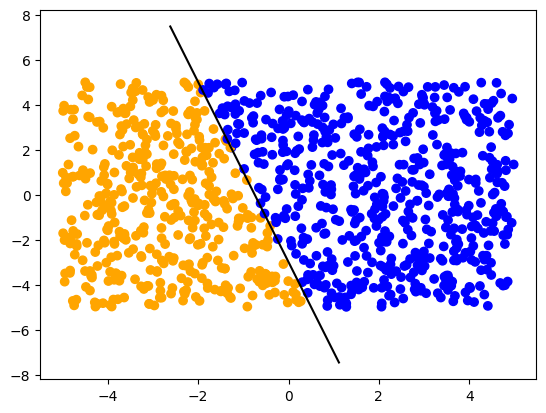

In [228]:
p = TwoDimProblem(5)
X, y = p.createData(1, 0, 1000)
p.plotData(True)


In [230]:
mlp = MultiLayerPerceptron(epochs=500, 
    lr=0.001, 
    input_layer=2, 
    output_layer=1, 
    hidden_layers=[5,3])
mlp.fit(X,y, batch_size=10)

In [229]:
from sympy import symbols
x = symbols('x')
p.seperator(x)

-4*x - 3

Accuracy = 0.995


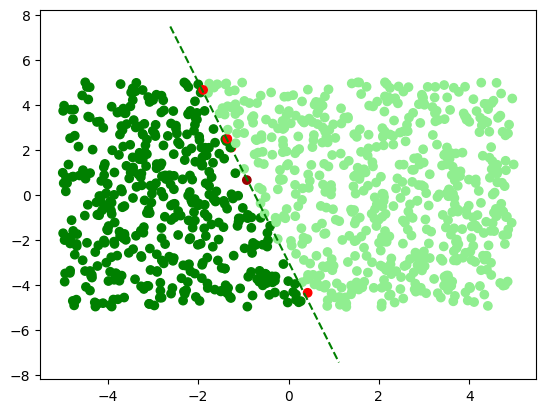

In [234]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', degree=5, gamma='auto')
clf.fit(X, y)
pred = clf.predict(X)
p.plotPred(pred, show_correct=True)

Accuracy = 0.881


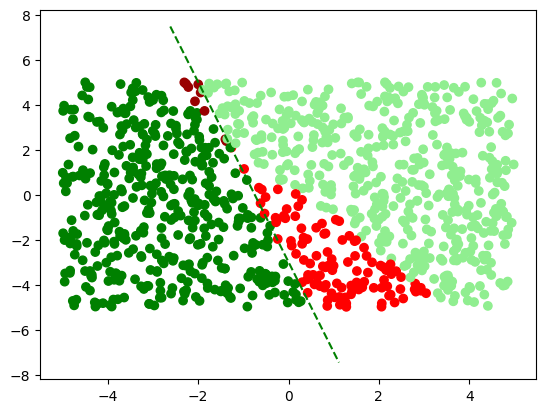

In [231]:
pred = mlp.predict(X)
p.plotPred(pred, show_correct=True)

# Test problem against 2d

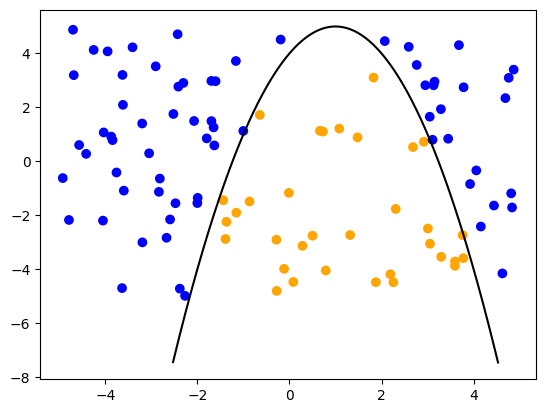

In [8]:
p = TwoDimProblem(5)
X, y = p.createData(2, 0, 100)
p.plotData(True)